In [1]:
import numpy as np
import nibabel as nib
import tensorflow as tf
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import os
import sys
import cv2

In [2]:
#Using GPU
tf.test.gpu_device_name() 

'/device:GPU:0'

In [3]:
#Mounting google drive

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
# load a .nii.gz format image
path = "drive/My Drive/Colab Notebooks/Experimental data2/"
folder_names = os.listdir(path)
# print(folder_names[0])
samples = []
labels = []
for folder in folder_names:
  # sub-01_dwi_sub-01_acq-multiband_dwi.bfc.nii.gz
  # sub-01_dwi_sub-01_acq-multiband_dwi.dwi.RAS.correct.L2.T1_coord.nii.gz
  # sub-01_dwi_sub-01_acq-multiband_dwi.dwi.RAS.correct.T1_coord.eig.nii.gz
  img = nib.load(os.path.join(path + folder + "/", "bdp/" + folder + "_dwi_" + folder +  "_acq-multiband_dwi.bfc.nii.gz"))
  label = nib.load(os.path.join(path + folder + "/" + "bdp/" + "bdp_output/" + folder + "_dwi_" + folder + "_acq-multiband_dwi.dwi.RAS.correct.T1_coord.eig.nii.gz"))

  # get data in a numpy array
  img_data = img.get_data()
  label_data = label.get_data()

  # covert data into float32 datatype
  I32 = np.float32(img_data)
  l32 = np.float32(label_data)
    
  # convert it back to float64
  I64 = np.float64(I32)
  l64 = np.float64(l32)

  #Resizing voxels to same dimensions
  # print(I64.shape[2])
  #Along depth
  # slices = [cv2.resize(I64[:,:, depth], (128, 128)) for depth in range(I64.shape[2])]
  # slices = np.asarray(slices)
  # slices = np.moveaxis(slices, 0, 2)
  # print(slices.shape)
  # Along width
  # samples_resized = [cv2.resize(slices[:,width, :], (72, 128)) for width in range(128)]
  # I64_resized = np.asarray(samples_resized)
  # print(I64_resized.shape)
  # I64_resized = np.moveaxis(I64_resized, 0, 1)

  samples.append(I64_resized)	
  labels.append(l64)

samples = np.asarray(samples)
labels = np.asarray(labels)

data code 0 not supported; not attempting fix


HeaderDataError: ignored

(176, 205, 136)
False


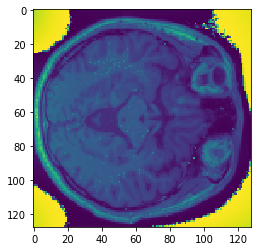

In [0]:
#Plotting sample
print(labels[0].shape)

plt.imshow(samples[1][:,:,35])
print(np.any(np.isnan(samples[0])))

(4, 128, 128, 72, 6)
False


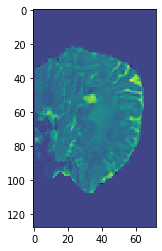

In [0]:
#Plotting labels
print(labels.shape)

plt.imshow(labels[1][50,:,:, 5])
print(np.any(np.isnan(labels[0])))

In [0]:
# some important variables

num_samples = len(samples)
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128
IMAGE_DEPTH = 72
batch_size = 1
volume_shape = [IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH]
input_shape = [batch_size, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH, 1]
output_shape = [batch_size, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH, 1]
n_epochs = 300

In [0]:
# training related variables
padding = 'SAME'
stride = [1,1,1]
learning_rate = 0.001

In [0]:
# the main method	
# start of tensorflow graph
#input and target placeholders
inputs_ = tf.placeholder(tf.float32, input_shape, name='inputs')
targets_ = tf.placeholder(tf.float32, input_shape, name='targets')



#network 14
#encoder
conv1 = tf.layers.conv3d(inputs= inputs_, filters=16, kernel_size=(3,3,3), padding= padding, strides = stride, activation=tf.nn.relu)
print("conv1", conv1.shape)	
maxpool1 = tf.layers.max_pooling3d(conv1, pool_size=(2,2,2), strides=(2,2,2), padding= padding)
print("pool1", maxpool1.shape)
conv2 = tf.layers.conv3d(inputs=maxpool1, filters=32, kernel_size=(3,3,3), padding= padding, strides = stride, activation=tf.nn.relu)
print("conv2", conv2.shape)
maxpool2 = tf.layers.max_pooling3d(conv2, pool_size=(2,2,2), strides=(2,2,2), padding= padding)
print("pool2", maxpool2.shape)
conv3 = tf.layers.conv3d(inputs=maxpool2, filters=96, kernel_size=(2,2,2), padding= padding , strides = stride, activation=tf.nn.relu)
print("conv3", conv3.shape)
maxpool3 = tf.layers.max_pooling3d(conv3, pool_size=(2,2,2), strides=(2,2,2), padding= padding)
print("pool3", maxpool3.shape)
#latent internal representation

#decoder
unpool1 = K.resize_volumes(maxpool3,2,2,2,"channels_last")
print("upool1", unpool1.shape)
deconv1 = tf.layers.conv3d_transpose(inputs=unpool1, filters=96, kernel_size=(2,2,2), padding= padding , strides = stride, activation=tf.nn.relu)
print("deconv1", deconv1.shape)
unpool2 = K.resize_volumes(deconv1,2,2,2,"channels_last")
print("upool2", unpool2.shape)
deconv2 = tf.layers.conv3d_transpose(inputs=unpool2, filters=32, kernel_size=(3,3,3), padding= padding , strides = stride, activation=tf.nn.relu)
print("deconv2", deconv2.shape)
unpool3 = K.resize_volumes(deconv2,2,2,2,"channels_last")
print("unpool3", unpool3.shape)
deconv3 = tf.layers.conv3d_transpose(inputs=unpool3, filters=16, kernel_size=(3,3,3), padding= padding , strides = stride, activation=tf.nn.relu)
print("deconv3", deconv3.shape)

output = tf.layers.dense(inputs=deconv3, units=1)
print("output", output.shape)
output = tf.reshape(output, input_shape)
# output shape = input shape


#loss function, optimizer and a saver to save weights&biases
loss = tf.norm(tf.subtract(targets_, output), ord = 'fro', axis = [-2,-1])
# print("loss", loss)
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)
all_saver = tf.train.Saver(max_to_keep = None)

#initializing a saver to save weights
#enc_saver = tf.train.Saver({'conv1': conv1, 'conv1_1': conv1_1, 'maxpool1': maxpool1, 'conv2': conv2, 'maxpool2': maxpool2, 'conv3': conv3, 'maxpool3': maxpool3, 'conv4': conv4})
#initializing a restorer to restore weights
#res_saver = tf.train.import_meta_graph('/weights/weights.meta')

# summary nodes
# tf.summary.scalar("loss", loss)
# tf.summary.scalar("cost", cost)
# tf.summary.histogram("conv1",conv1)
# tf.summary.histogram("conv1_1",conv1_1)
# tf.summary.histogram("maxpool1",maxpool1)
# tf.summary.histogram("conv2",conv2)
# tf.summary.histogram("maxpool2",maxpool2)
# tf.summary.histogram("conv3",conv3)
# tf.summary.histogram("maxpool3",maxpool3)
# tf.summary.histogram("conv4",conv4)
# tf.summary.histogram("deconv4",deconv4)
# tf.summary.histogram("unpool3",unpool3)
# tf.summary.histogram("deconv3",deconv3)
# tf.summary.histogram("unpool2",unpool2)
# tf.summary.histogram("deconv2",deconv2)
# tf.summary.histogram("unpool1",unpool1)
# tf.summary.histogram("deconv1_1",deconv1_1)
# tf.summary.histogram("deconv1",deconv1)

# summary operation and a writer to save it.
# summary_op = tf.summary.merge_all()
# writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())

# end of tensorflow graph

# initializing tensorflow graph and a session
init_op = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init_op)

avg_cost = []
#training
for epoch in range(n_epochs):
  total_cost = 0
  for j in range(num_samples//batch_size):
    # print("1", samples.shape)
    input = samples[j].reshape(input_shape)
    target = labels[j][:,:,:, 0].reshape(output_shape)
    batch_cost,_ = sess.run([cost,opt], feed_dict = {inputs_: input, targets_: target})
    total_cost += batch_cost
  avg_cost.append(total_cost/num_samples)
  print("Epoch: {}...".format(epoch), "Average training loss: {:.4f}".format(total_cost/num_samples))

Instructions for updating:
Use `tf.keras.layers.Conv3D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
conv1 (1, 128, 128, 72, 16)
Instructions for updating:
Use keras.layers.MaxPooling3D instead.
pool1 (1, 64, 64, 36, 16)
conv2 (1, 64, 64, 36, 32)
pool1 (1, 32, 32, 18, 32)
conv3 (1, 32, 32, 18, 96)
pool3 (1, 16, 16, 9, 96)
upool1 (1, 32, 32, 18, 96)
Instructions for updating:
Use `tf.keras.layers.Conv3DTranspose` instead.
deconv1 (1, 32, 32, 18, 96)
upool2 (1, 64, 64, 36, 96)
deconv2 (1, 64, 64, 36, 32)
unpool3 (1, 128, 128, 72, 32)
deconv3 (1, 128, 128, 72, 16)
Instructions for updating:
Use keras.layers.Dense instead.
output (1, 128, 128, 72, 1)
Epoch: 0... Training loss: 247.1017
Epoch: 1... Training loss: 36.3468
Epoch: 2... Training loss: 4.6547
Epoch: 3... Training loss: 2.4758
Epoch: 4... Training loss: 1.4815
Epoch: 5... Training loss: 1.0019
Epoch: 6... Training loss: 0.7697
Epoch: 7... Training loss: 0.4823
Epoch: 8... Training loss: 0.4124
E

KeyboardInterrupt: ignored

In [0]:
plt.title('Training loss curve')
plt.xlabel(n_epochs)
plt.ylabel(avg_cost)
plt.plot(n_epochs, avg_cost)

NameError: ignored

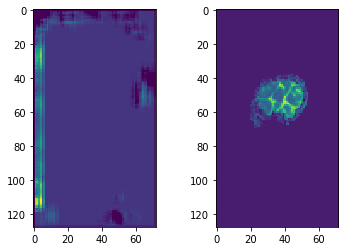

In [0]:
#Testing

for j in range(num_samples//batch_size):
    input_test = samples[j].reshape(input_shape)
    output_test = sess.run(output, feed_dict = {inputs_: input_test})
    target = labels[j][:,:,:, 0].reshape(output_shape)

# Displaying predicted 3D DTI images
fig1=plt.figure()
columns = 2
rows = 1

fig1.add_subplot(rows, columns, 1)
plt.imshow(output_test[0][100,:,:,0])
fig1.add_subplot(rows, columns, 2)
plt.imshow(target[0][100,:,:,0])

fig2=plt.figure()
fig2.add_subplot(rows, columns, 1)
plt.imshow(samples[0][:,100,:,0])
fig2.add_subplot(rows, columns, 2)
plt.imshow(output[0][:,100,:,0])

fig3=plt.figure()
fig3.add_subplot(rows, columns, 1)
plt.imshow(samples[0][:,:,100,0])
fig3.add_subplot(rows, columns, 2)
plt.imshow(output[0][:,:,100,0])